In [158]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import io
import seaborn as sns

In [159]:
import requests
#url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
url= "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

raw_data=requests.get(url).content

# another source
#  https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-23.csv



In [160]:

str_data = raw_data.decode('utf-8')
with open("time_series_19-covid-Confirmed.csv",'w') as f:
    f.write(str_data)

corona_data = pd.read_csv(io.StringIO(str_data))
#print(corona_data.columns)
corona_data.head(10)
first_data_col = corona_data.columns.to_list().index("1/22/20")
print(f"1st data column : {first_data_col}")
print(f"Last data column : {corona_data.columns[-1]}")
assert first_data_col>2
last_date = corona_data.columns[-1]

1st data column : 4
Last data column : 3/24/20


In [161]:
countries = corona_data['Country/Region']
provinces = corona_data['Province/State']
curr_cases = corona_data[corona_data.columns[-1]]
limit = 5000

geos = { c+("/"+str(p) if p is not np.nan else "") :(i,c,(str(p) if p is not np.nan else ""),s) for c,p,s,i in zip(countries,provinces,curr_cases,range(len(countries))) } ##if s>=limit}
print(f"Total {len(geos)} geo locations with current caeses count > {limit}") 
#print(list(k+str(v) for k,v in geos.items()[:10]))

us_rows = []
for k,v in geos.items():
    if k.startswith("US"):
        us_rows.append(v[0])

print("Number of Us locations:: ",len(us_rows))        
        


Total 241 geo locations with current caeses count > 5000
Number of Us locations::  1


In [162]:
 def get_series(i):
        fr =  corona_data.iloc[i,first_data_col:]
        return np.array([f for f in fr if f>100 ])
    
def get_series_US():
        us_series = corona_data.iloc[us_rows[0],first_data_col:]
        for i in us_rows[1:]:
            us_series =  np.add(us_series,corona_data.iloc[i,first_data_col:])
        
        return np.array([f for f in us_series if f>100 ])    
    
def print_nicely(s):
    a = s[-1]
    d = s[-1]-s[-2] if len(s)>1 else 0
    
    dp = "+" if d>0 else ""
    if d<1000:
        dp += "%d" %d
    elif d<10000:
        dp+= "%.1fk" % (d/1000)
    else: 
        dp+= "%.12M" % (d/1000000)
    
    
    if a < 1000: return "%d (%s)" % (a,dp)
    if a < 1000000: return "%.1fk (%s)" % (a/1000,dp)
    return "%.2fM (%s)" % (a/1000000,dp)
    
    
    

dict_keys(['Austria', 'France', 'Germany', 'Iran', 'Italy', 'Netherlands', 'Spain', 'Switzerland', 'United Kingdom', 'US'])
Montenegro cases: 47


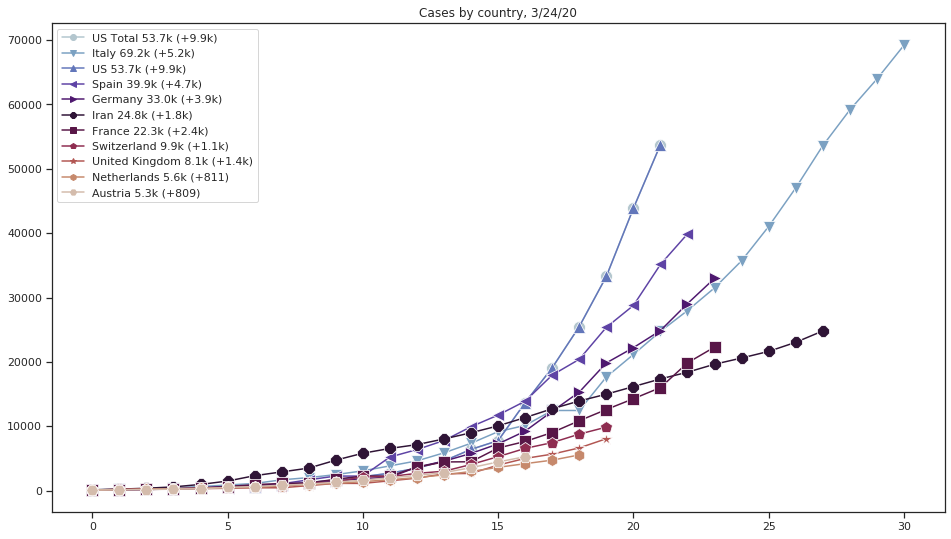

In [163]:
from functools import reduce
skip_china = True
skip_korea = True
series = { c : get_series(geos[c][0]) for c,v in geos.items() if v[3]>limit and (not skip_china or not c.startswith("China")) and (not skip_korea or not c.startswith("Korea")) }

print(series.keys())
print ("Montenegro cases:",geos["Montenegro"][3])

#max_days = reduce(max,map(len,series.values()))
#print (f"Max days {max_days}")
sns.set(style="ticks")

data = pd.DataFrame ()

sorted_keys = list(series.keys())
sorted_keys.sort(key = lambda a: -series[a][-1])

us_series = get_series_US()
data = pd.concat([data,pd.DataFrame ({f"US Total {print_nicely(us_series)}":us_series})],axis=1)

for c in sorted_keys:
    s = series[c]
    data = pd.concat([data,pd.DataFrame ({f"{c} {print_nicely(s)}":s})],axis=1)

    
    
plt.figure(figsize=(16, 9))
plt.title("Cases by country, "+ last_date)
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
sns.lineplot(data = data, palette="twilight", hue="label",linewidth=1.5, dashes = False,style= True, markers = filled_markers, markersize=12)


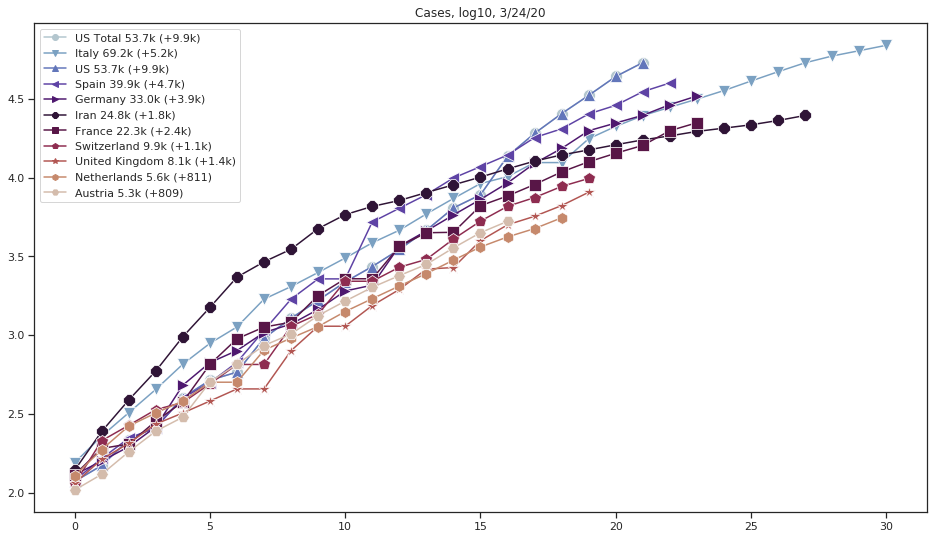

In [164]:
from math import log10
plt.figure(figsize=(16, 9))
plt.title("Cases, log10, "+ last_date)

sns.lineplot(data = data.applymap(log10), palette="twilight", hue="label",linewidth=1.5, dashes = False,style= True, markers = filled_markers, markersize=12)

